In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import numpy as np
import tomosipo as ts
import torch
from ts_algorithms import fbp, fdk, sirt

from autodiffCT.operator.basic import ApplyRoiOperator
from autodiffCT.optimizer import PyTorchOptimizer
from autodiffCT.pipeline import SequentialPipeline
from autodiffCT.tomography.project import BackprojectOperator
from autodiffCT.tomography.reconstruction import (
    PyTorchFbpOperator, PyTorchFdkOperator, PyTorchSirtOperator,
    ShiftRotationAxisOperator)

from autodiffCT.loss import VarianceLossFn


def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    fig.patch.set_alpha(1.0)
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()
    plt.show()


class Logger:
    def __init__(self):
        self.loss_history = []
        self.shift_history = []
        self.recs = []
        self.shift = 0
    
    def log(self, optimizer_object):
        self.loss_history.append(optimizer_object.loss.item())
        self.shift_history.append(self.shift)
        self.shift = optimizer_object.pipeline.operators[0].parameters['shift'].value.item()
        if optimizer_object.iter_n % 10 == 0:
            self.recs.append(optimizer_object.output.detach().clone().cpu().squeeze())

# Simulate data with a shifted rotation axis

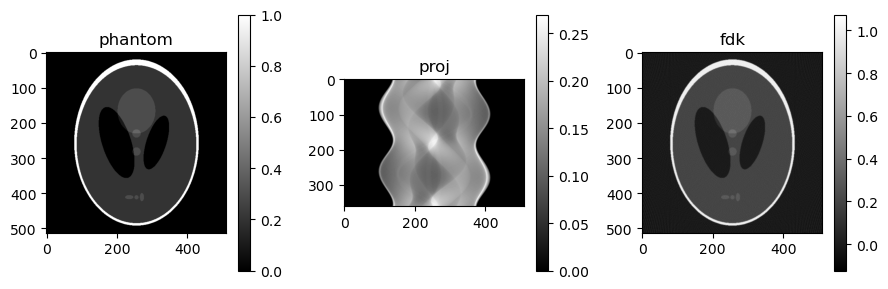

In [2]:
phantom = np.load('shepp_logan_phantom.npz')['phantom']
phantom = torch.tensor(phantom, device='cuda')

vg = ts.volume(shape=(1, 512, 512), size=(1/512, 1, 1))
pg = ts.cone(angles=360, shape=(1, 512), size=1.5, cone_angle=0.5)
projector = ts.operator(vg, pg)

proj = projector(phantom.unsqueeze(dim=0))
# Poisson noise
I0 = 10000
proj = torch.poisson(I0 * proj) / I0
proj = -torch.log(torch.poisson(I0 * torch.exp(-proj)) / I0)
# Gaussian noise
# proj += 0.1 * proj.mean() * torch.randn(proj.shape, device=proj.device)

plot_imgs(phantom=phantom, proj=proj, fdk=fdk(projector, proj))

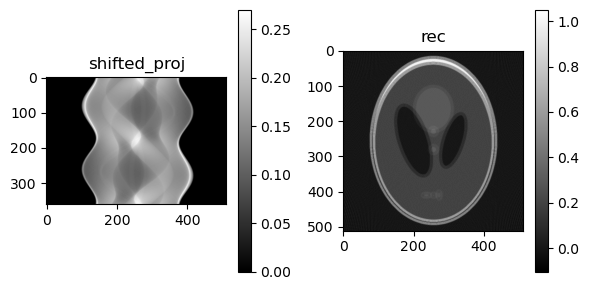

In [3]:
AXIS_SHIFT = 3
shifted_proj = proj.roll(AXIS_SHIFT, dims=2)

plot_imgs(shifted_proj=shifted_proj, rec=fdk(projector, shifted_proj))

# Find the rotation axis shift by optimizing for the contrast of the reconstruction

In [4]:
roi = np.index_exp[:]

shift_axis_op = ShiftRotationAxisOperator()
pipeline = SequentialPipeline([
    shift_axis_op,
    BackprojectOperator(projector),
    # PyTorchFbpOperator(projector),
    # PyTorchFdkOperator(projector),
    # PyTorchSirtOperator(projector, n_iter=20),
    ApplyRoiOperator(roi)
])

lr = 1e9
optimizer_class = torch.optim.SGD
optimizer = PyTorchOptimizer(pipeline, optimizer_class,
                             target_parameters=[shift_axis_op.parameters['shift']],
                             lr=lr)

contrast_measure = VarianceLossFn()

logger = Logger()
optimal_shift = optimizer.optimize(loss_func=contrast_measure,
                                   inputs=[[shifted_proj]],
                                   n_iterations=6, callback=logger.log)
optimal_shift

100%|██████████| 6/6 [00:00<00:00, 61.62it/s]


[tensor(-3.0002, requires_grad=True)]

Text(0.5, 1.0, 'Backprojection (after)')

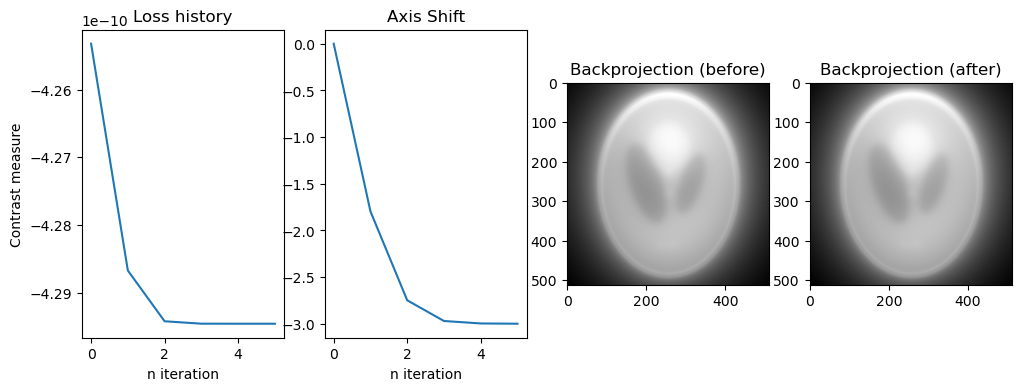

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
axes[0].plot(logger.loss_history)
axes[0].set_xlabel('n iteration')
axes[0].set_ylabel('Contrast measure')
axes[0].set_title('Loss history')
axes[1].plot(logger.shift_history)
axes[1].set_xlabel('n iteration')
axes[1].set_title('Axis Shift')
axes[2].imshow(logger.recs[0])
axes[2].set_title('Backprojection (before)')
axes[3].imshow(logger.recs[-1])
axes[3].set_title('Backprojection (after)')

Text(0.5, 1.0, 'FDK reconstruction (aligned)')

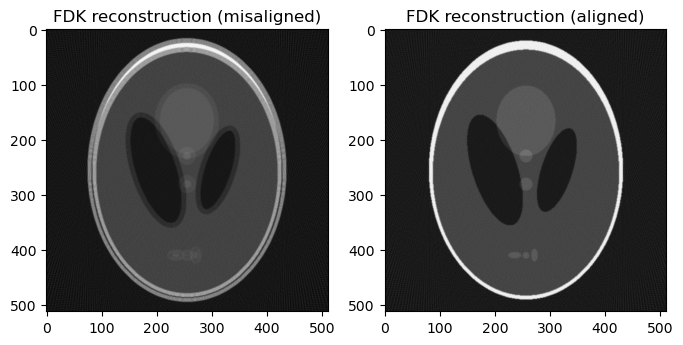

In [82]:
fdk_before = fdk(projector, shifted_proj).cpu().squeeze()
fdk_after = fdk(projector, shift_axis_op(shifted_proj)).cpu().squeeze()

fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
axes[0, 0].imshow(fdk_before)
axes[0, 0].set_title('FDK reconstruction (misaligned)')
axes[0, 1].imshow(fdk_after)
axes[0, 1].set_title('FDK reconstruction (aligned)')

# Save results

In [126]:
from datetime import datetime
import os


log_path = f'experimental_results/{datetime.today():%Y-%m-%d}'
os.makedirs(log_path, exist_ok=True)
np.savez_compressed(f'{log_path}/rotation_axis_alignment_simulated_results.npz',
                    poisson_I0=I0, n_angles=pg.num_angles, shift=AXIS_SHIFT,
                    optimizer=optimizer_class, lr=lr, loss_fn=type(contrast_measure),
                    losses=logger.loss_history, shifts=logger.shift_history,
                    fdk_before=fdk_before, fdk_after=fdk_after)